<a href="https://colab.research.google.com/github/Atomnp/realtime_text_similarity_backend/blob/main/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [27]:
import pandas as pd
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, lil_matrix
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [29]:
stop_words=["?","n't","'s"]
stop_words+=nltk.corpus.stopwords.words('english')

In [30]:
# mounting your google drive to colab
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Loading the data

**Make shortcut of [this](https://drive.google.com/drive/folders/1BGr0cWKiJwT_jNg9nRNAhWgy0mYPgw_K?usp=sharing) folder in your gdrive**

In [173]:
# load dataset
dataset = r'/gdrive/MyDrive/minor_project_files/dataset.txt'
dataset = r'/gdrive/MyDrive/minor_project_files/filtered.txt'
dataset = r'/gdrive/MyDrive/minor_project_files/validate.txt'

# df= pd.read_csv(dataset, keep_default_na=False, na_values=['_'])
questions = []
with open(dataset,"r") as fp:
  # questions=[x.strip().lower() for x in fp.readlines()]
  questions = [x.strip().lower().split("?,") for x in fp.readlines() if x != "\n"]

In [167]:
len(questions)

296559

In [174]:
cluster = [question[1] for question in questions]
questions = [question[0] for question in questions]

In [121]:
questions = questions[:1000]

In [178]:
# tokenize sentences
sentences = (word_tokenize(sentence.lower()) for sentence in questions)

#Word2Vec Model (Train, Save and Load)

In [169]:
import copy 
from matplotlib import pyplot as plt
import time
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    '''Callback for Word2vec with resetting loss on the end of each epoch.'''

    def __init__(self):
        self.epoch = 1

        self.epoch = 1
        self.losses = []
        self.cumu_loss = 0.0
        self.previous_epoch_time = time.time()

        self.best_model = None
        self.best_loss = 1e+30

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()

        norms = [np.linalg.norm(v) for v in model.wv.vectors]
        now = time.time()
        epoch_seconds = now - self.previous_epoch_time
        self.previous_epoch_time = now
        self.cumu_loss += float(loss)
        print(f"Loss after epoch {self.epoch}: {loss} (cumulative loss so far: {self.cumu_loss}) "+\
              f"-> epoch took {round(epoch_seconds, 2)} s - vector norms min/avg/max: "+\
              f"{round(float(min(norms)), 2)}, {round(float(sum(norms)/len(norms)), 2)}, {round(float(max(norms)), 2)}")
        self.epoch += 1

        self.losses.append(float(loss))

        # reset loss inside model
        model.running_training_loss = 0.0

        if loss < self.best_loss:
            self.best_model = copy.deepcopy(model)
            self.best_loss = loss

        if self.epoch % 50 == 0:
            self.plot(path="/word2vec/w2v_training_loss.png")

    def plot(self, path):
        fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 6))
        ax1.plot(self.losses, label="loss per epoch")
        plt.legend()
        plt.savefig(path)
        plt.close()
        print("Plotted loss.")

In [171]:
# uncomment if you want to retrain the word2vec model

it_copy, sentences = itertools.tee(sentences)

# min_count, window=3?? !!
model = Word2Vec(sentences=list(it_copy), size=100, window=5, min_count=1, workers=4, compute_loss=True, iter=5, callbacks=[callback2()])
model_wv = model.wv
model.save("/gdrive/MyDrive/minor_project_files/word2vec.model")
# # model = FastText( window=3, min_count=1)  # instantiate
# # model.build_vocab(sentences=it_copy)
# # model.train(sentences=it_copy, total_examples=len(questions), epochs=10)  # train
# # model.save("/gdrive/MyDrive/minor_project_files/fasttext.model")

Loss after epoch 1: 1761559.375 (cumulative loss so far: 1761559.375) -> epoch took 25.62 s - vector norms min/avg/max: 0.02, 0.33, 15.16
Loss after epoch 2: 1455617.5 (cumulative loss so far: 3217176.875) -> epoch took 7.52 s - vector norms min/avg/max: 0.03, 0.5, 18.18
Loss after epoch 3: 1321846.625 (cumulative loss so far: 4539023.5) -> epoch took 9.33 s - vector norms min/avg/max: 0.03, 0.62, 20.24
Loss after epoch 4: 1215837.125 (cumulative loss so far: 5754860.625) -> epoch took 10.55 s - vector norms min/avg/max: 0.03, 0.68, 22.02
Loss after epoch 5: 1203927.875 (cumulative loss so far: 6958788.5) -> epoch took 11.82 s - vector norms min/avg/max: 0.03, 0.7, 22.78


In [36]:
# load already saved word2vec model
# model = FastText.load("/gdrive/MyDrive/minor_project_files/fasttext.model")
# model = Word2Vec.load("/gdrive/MyDrive/minor_project_files/word2vec.model")
# model_wv = model.wv

# tSNE visualization of Word2Vec(Visualizing word embeddings)

In [176]:
len(questions)

192

In [38]:
model.wv.vocab.keys()

dict_keys(['a', 'space', 'is', 'being', 'inserted', 'after', 'first', 'letter', 'of', 'some', 'words', 'in', 'text', 'ms', 'word', '.', 'eg', '``', 'q', 'uora', "''", 'instead', 'quora', 'how', 'do', 'i', 'fix', 'this', '?', 'what', "'s", 'it', 'like', 'to', 'work', 'at', 'care.com', 'for', 'your', 'job', 'were', 'the', 'german', 'jews', 'treated', 'before', 'hitler', 'and', 'wwi', 'why', 'sugar', 'bad', 'us', 'can', 'deal', 'with', 'death', 'grandparent', 'best', 'available', 'compact', 'camera', ',', 'sony', 'cyber-shot', 'dsc-rx100', 'or', 'other', 'there', 'anything', 'better', 'coming', 'out', 'next', '2-3', 'months', 'way', 'build', 'an', 'email', 'list', 'humanity', 'part', 'experiment', 'are', 'we', 'someone', 'terrarium', 'unix', 'downloadable', 'you', 'calculate', 'chemical', 'formula', 'ammonium', 'chlorate', 'sentence', 'correct', 'let', 'me', 'know', 'results', 'set', 'facebook', 'restrict', 'others', 'from', 'seeing', 'my', 'friends', 'riddles', 'examples', 'thought', 'pr

In [175]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(list(model.wv.vocab.keys()))  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


plot_with_matplotlib(x_vals, y_vals, labels)

KeyboardInterrupt: ignored

In [ ]:
model.most_similar('china')

[('russia', 0.8371441960334778),
 ('pakistan', 0.8326873779296875),
 ('taiwan', 0.8066251277923584),
 ('japan', 0.8063627481460571),
 ('israel', 0.7937995195388794),
 ('iran', 0.7846527695655823),
 ('indonesia', 0.7798824310302734),
 ('america', 0.7784489393234253),
 ('philippines', 0.765444278717041),
 ('france', 0.7598271369934082)]

^^ First train the model on the entire dataset

#Alternative word embedding method: GloVe

In [ ]:
# GloVe Model embeddings matrix
embeddings_index = dict()

# reading Glove word embeddings into a dictionary with "word" as key and values as word vectors
with open('/gdrive/MyDrive/minor_project_files/glove.6B.100d.txt') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

model_wv = embeddings_index

#TFIDF for finding important words in a sentence

In [179]:
def identity_tokenizer(text):
      return text

# lowercase !!
vect = TfidfVectorizer(stop_words=stop_words, use_idf=True, tokenizer=identity_tokenizer,lowercase=False)    
# copy the iterator so that the cell can be rerun (otherwise the iterator will be at the end)
it_copy, sentences = itertools.tee(sentences)
tfidf_matrix = vect.fit_transform(it_copy)
fv = vect.get_feature_names()

In [180]:
# implementation to find sentence embeddings (alternative 1) : lil_matrix! 2m4s!!

# cx = coo_matrix(tfidf_matrix)
cx = lil_matrix(tfidf_matrix)

#Find sentence Embeddings for each sentence in the dataset


1.   Find most important words
2.   Lookup their word vectors from word2vec/glove model
3.   Save the average word vector as the sentence embedding



In [181]:
def encode_array(sentences: str, embedding_size=100):
        embeddings = []
        for sentence in sentences:
            to_transform = word_tokenize(sentence)
            matrix = vect.transform([to_transform])
            cx = coo_matrix(matrix)

            sorted_by_tfidf = sorted(
                [(fv[j], v) for i, j, v in zip(cx.row, cx.col, cx.data)],
                key=lambda x: x[1],
                reverse=True,
            )
            filtered = list(
                filter(lambda x: x[0] in model.wv, sorted_by_tfidf)
            )
            if filtered == []:
                embeddings.append(np.random.randn(embedding_size))
                continue
            arrlist = np.array(
                list(map(lambda x: model.wv[x[0]], filtered[:5]))
            )

            sentence_embedding = np.mean(arrlist, axis=0)

            if type(sentence_embedding) == np.ndarray:
                embeddings.append(sentence_embedding)
            else:
                embeddings.append(np.random.randn(embedding_size))
        return embeddings

In [182]:
sem = encode_array(questions)

In [183]:
len(sem)

192

In [184]:
len(questions)

192

In [62]:
# sem = []
# to = cx.get_shape()[0]
# for i in range(to):
#   rx = cx.getrow(i).tocoo()

#   sorted_by_tfidf = sorted([(fv[j],v) for k,j,v in zip(rx.row, rx.col, rx.data)], key=lambda x: x[1], reverse=True)
#   # if i in [1,500,1000]:
#   #   print(sorted_by_tfidf)

#   sorted_by_tfidf = list(filter(lambda x: x[0] in model_wv, sorted_by_tfidf))
#   arrlist = np.array( list(map(lambda x: model_wv[x[0]], sorted_by_tfidf[:5])  ))

#   sem.append(np.mean(arrlist, axis=0))

# sem = np.asarray(sem)
# np.save('/gdrive/MyDrive/minor_project_files/sentence_embeddings5.npy', sem)
# np.save('/gdrive/MyDrive/minor_project_files/glove_sentence_embeddings4.npy', sem)


In [ ]:
sem = np.load('/gdrive/MyDrive/minor_project_files/sentence_embeddings4.npy', allow_pickle=True)
print(sem[:1])

# Sentence Clustering Visualization

In [138]:
import tensorflow_hub as hub
import numpy as np


class UniversalEncoder():
    def __init__(
        self, model_path: str = "https://tfhub.dev/google/universal-sentence-encoder/4"
    ):
        self.embedding_size = 512
        self.model = hub.load(model_path)
    
    def encode(self, sentence):
        embeddings = self.model([sentence])
        return embeddings[0]

    def encode_array(self, sentences):
        embeddings = self.model(sentences)
        return embeddings

In [139]:
encoder = UniversalEncoder()
sem = encoder.encode_array(questions)

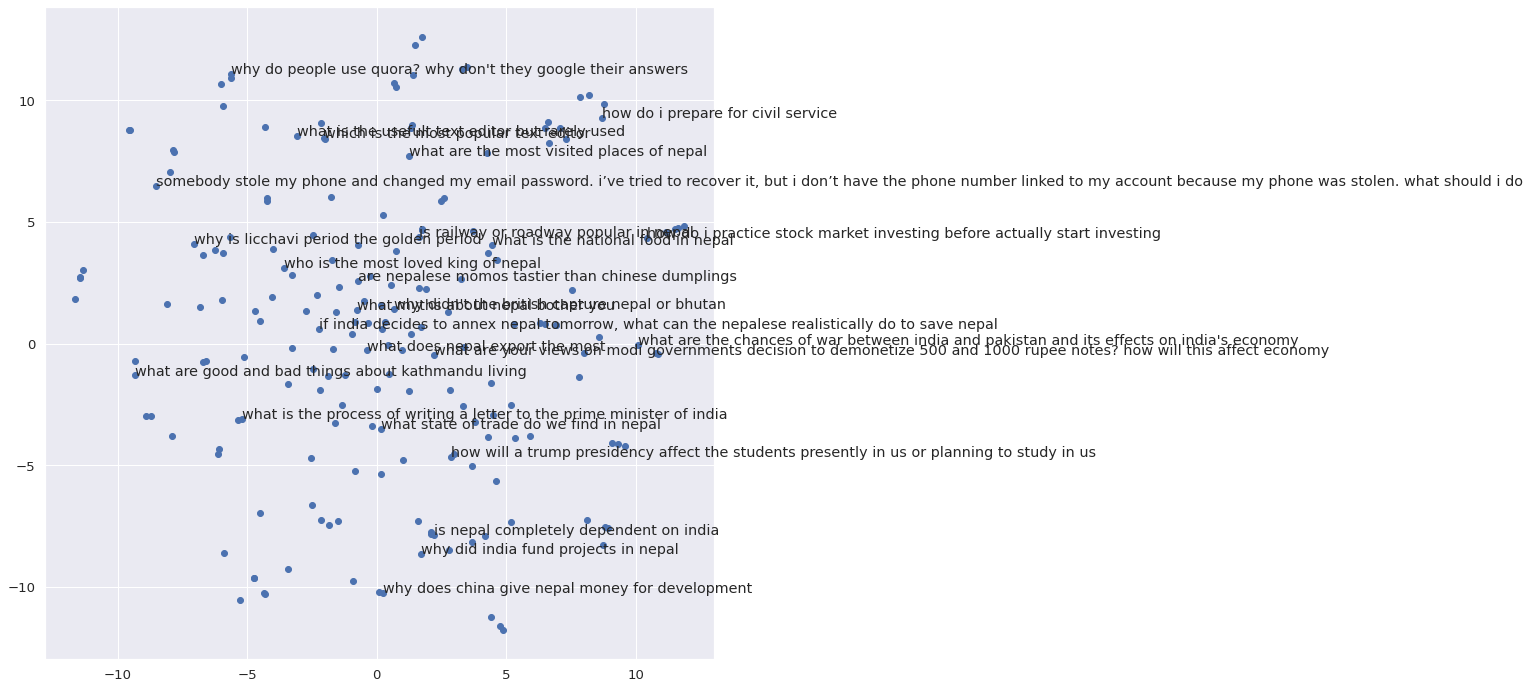

In [185]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model_vectors, labels):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    # vectors = np.asarray(model_vectors)
    vectors = model_vectors
    labels = np.asarray(list(labels))  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(sem, questions)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


plot_with_matplotlib(x_vals, y_vals, labels)

In [109]:
questions[6]

'who is the founder of buddhism?'

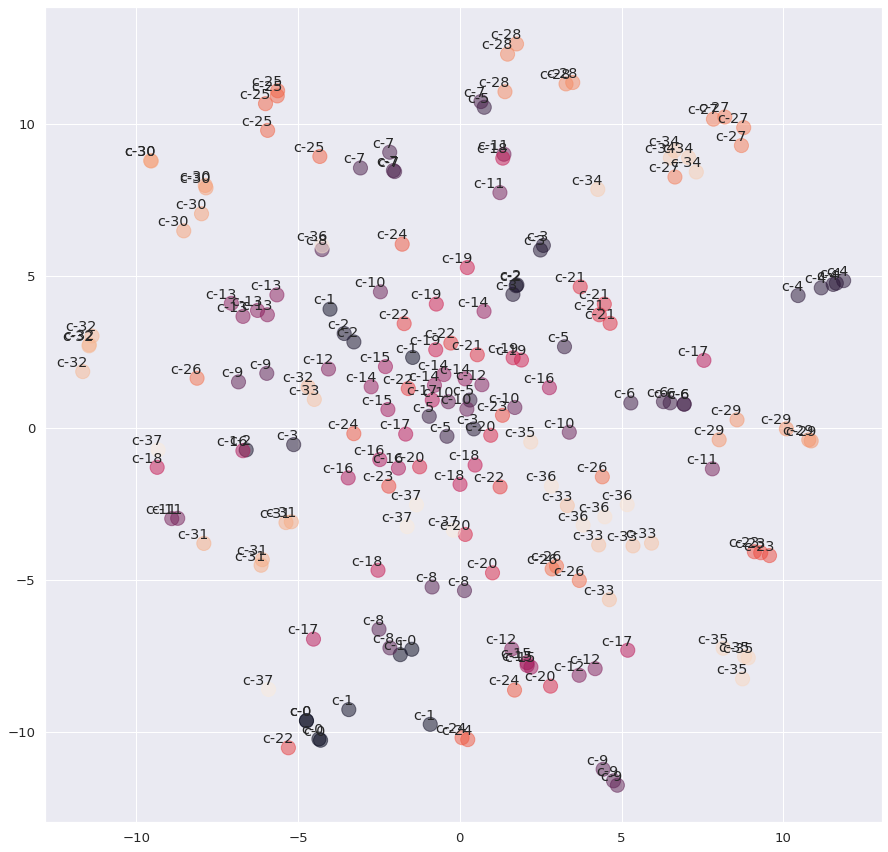

In [186]:
import matplotlib.pyplot as plt

labels = questions
coord_x = x_vals
coord_y = y_vals
assigned_clusters = [int(c) for c in cluster]
# Plot sentences
plt.figure(figsize=(15, 15))
plt.scatter(coord_x, coord_y, c=assigned_clusters, s=200,alpha=.5)
# sentences = data['text']

for j in range(len(questions)):
    plt.annotate(
        f"c-{assigned_clusters[j]}",
        xy=(coord_x[j], coord_y[j]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right', va='bottom')

plt.show()

# Heatmap of Similar and Dissimilar sentences


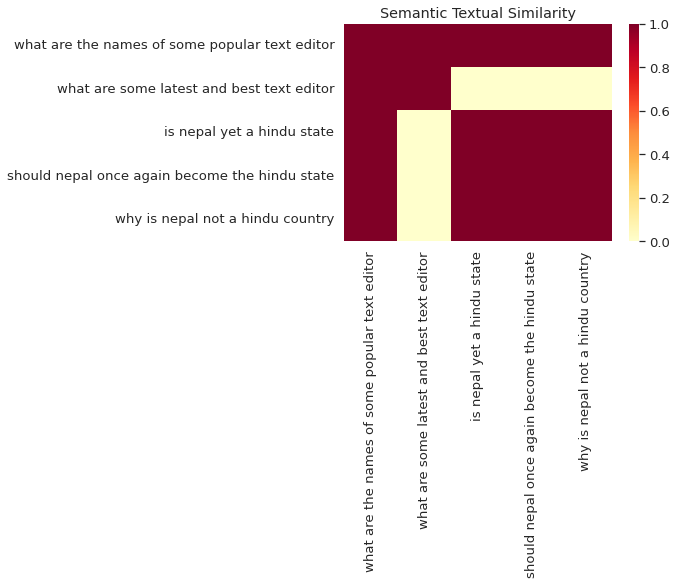

In [189]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(corr,\
        xticklabels=labels,\
        yticklabels=labels,\
        vmin=0,\
        vmax=1,\
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    plt.tight_layout()
    plt.savefig("Avenger-semantic-similarity.png")
    plt.show()

plot_similarity(questions[38:43], sem[38:43], 90)

#Build Annoy Index for finding approximate nearest neighbours (and corresponding label) 

In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 7.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391681 sha256=76d0fb11f71afc47bbb61956de64d90dd7eef42e8f2a054516d900d20b389994
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
import annoy
import pickle
class AnnoyIndex():
    def __init__(self,dimension):
        self.dimension = dimension
        self.index = annoy.AnnoyIndex(self.dimension)   
   
    def build(self,vectors, labels, number_of_trees=5):
        self.vectors = vectors
        self.labels = labels 

        for i, vec in enumerate(self.vectors):
          if not np.isnan(np.sum(vec)):
            self.index.add_item(i, vec)
        self.index.build(number_of_trees)
        
    def query(self, vector, k=10):
        indices = self.index.get_nns_by_vector(
              list(vector), 
              k)                                           
        return [self.labels[i] for i in indices]
    def save(self,path):
        label_path=path.split(".")[0]+".labels"
        print(label_path)
        with open(label_path,'wb') as fp:
            pickle.dump(self.labels,fp)
        self.index.save(path)
    
    def load(self,path):
        label_path=path.split(".")[0]+".labels"
        self.index=annoy.AnnoyIndex(self.dimension)
        with open(label_path,"rb") as fp:
            self.labels=pickle.load(fp)
        self.index.load(path)

In [ ]:
questions = []
with open(dataset,"r") as fp:
  questions=fp.readlines()

In [ ]:
# create annoy index from vectors
index = AnnoyIndex(dimension=len(sem[0]))
index.build(sem, questions)

In [ ]:
index.save('/gdrive/MyDrive/minor_project_files/annoy_index.ann')
# index.save('/gdrive/MyDrive/minor_project_files/annoy_index_glove.ann')

/gdrive/MyDrive/minor_project_files/annoy_index.labels


In [ ]:
index.query(sem[500])
# print(questions[1])
# print(sem[1])

['What are the civil law examples?\n',
 'What factors of industrial revolution?\n',
 'What are the major aspects of the Victorian literature?\n',
 'What are some of the key invention from The Industrial Revolution?\n',
 'What are the major challenges of gene therapy using the CRISPR system?\n',
 'Can I major in biology as a Christian?\n',
 'What are the differences between civil and criminal cases?\n',
 "What are the major characteristics of an ostrich's beak?\n",
 'What are some of the major problems in democracy?\n',
 'Are there any relation between a major in economics and a major in philosophy?\n']

In [ ]:
type(vect)


sklearn.feature_extraction.text.TfidfVectorizer

In [ ]:
with open("/gdrive/MyDrive/minor_project_files/tf_vectorizer.pickle","wb") as fp:
  pickle.dump(vect,fp)

In [ ]:
vect1=None
with open("/gdrive/MyDrive/minor_project_files/tf_vectorizer.pickle","rb") as fp:
  vect=pickle.load(fp)

In [ ]:
#  load existing annoy index from file
loaded_index = AnnoyIndex(dimension=len(sem[0]))
loaded_index.load('/gdrive/MyDrive/minor_project_files/annoy_index.ann')

OSError: ignored

In [ ]:
loaded_index.query(sem[499])

['Could an extremely advanced civilization, in the far future, deactivate and store red and brown dwarfs to delay heat death?\n',
 'Why do I feel extreme anger and crave revenge for any slight, no matter how insignificant?\n',
 'I have no gyno (tested) yet my nipples are puffy and they look like female breasts. Why?\n',
 'Why do some Orthodox Jewish circumcisions involve the mohel using his mouth to draw blood?\n',
 'Are most women attracted to men with overly masculine faces, overly feminine faces, or in-between? What influences their preference?\n',
 "How do I stop my son who has Asperger's from destroying his bedroom walls and hurting people when he's in a rage?\n",
 'Do you think the climate of arrogant rudeness afforded by Internet anonymity will ever spill over to the real world?\n',
 'What are the sexiest pornstars?\n',
 'How do spiders mate?\n',
 'Can I commit mental disorder disability fraud at age 30 if I have 240k saved up from my job?\n']

In [ ]:
def get_similar(input_question:str):
    # get sentence embedding of the question
    to_transform = word_tokenize(input_question)
    matrix = vect.transform([to_transform])
    # print(matrix)
    cx = coo_matrix(matrix)

    sorted_by_tfidf = sorted([(fv[j],v) for i,j,v in zip(cx.row, cx.col, cx.data)], key=lambda x: x[1], reverse=True)
    
    # print(sorted_by_tfidf)
    filtered = list(filter(lambda x: x[0] in model_wv, sorted_by_tfidf))

    arrlist = np.array( list(map(lambda x: model_wv[x[0]], sorted_by_tfidf[:5])  ))

    sentence_embedding = np.mean(arrlist, axis=0)
    # print(sentence_embedding)
    return index.query(sentence_embedding)

In [ ]:
#@title { run: "auto" }
query = "how do i get into mit?" #@param {type:"string"}

print("Finding relevant items in the index...")
print(get_similar(query))
# %time query_embedding = get_similar(query)


Finding relevant items in the index...
['How do I get into MIT?\n', 'How IS TO get into MIT?\n', 'Can I get into MIT?\n', 'Do we get scholarships at MIT?\n', 'How can I get MIT lectures?\n', 'How can I get into Harvard Unversity?\n', 'How do I get into Harvard?\n', 'How do I get in Harvard?\n', 'How to get admissions in MIT?\n', 'How did you get admitted to MIT?\n']


#Running Flask on collab

In [ ]:
%%capture
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null
!echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list
!sudo apt update && sudo apt install ngrok
!pip install flask_ngrok flask-bootstrap
!pip install flask_restful flask_cors
!cat /gdrive/MyDrive/minor_project_files/ngrok_token | xargs ngrok authtoken

In [ ]:
import sys
stdout = sys.stdout
stderr = sys.stderr

In [ ]:
print("test")

test


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template , request , jsonify
from flask_restful import Resource, Api
import os, logging, sys
from flask_cors import CORS, cross_origin

# sys.stdout = open("/gdrive/MyDrive/minor_project_files/test.txt", "w", buffering=1)
# sys.stderr = open("/gdrive/MyDrive/minor_project_files/test.txt", "a", buffering=1)

app = Flask(__name__)
cors = CORS(app, resources={r"/*": {"origins": "*"}})
# cors = CORS(app)
# app.config['CORS_HEADERS'] = 'Content-Type'
api = Api(app)

run_with_ngrok(app)


class Similarity(Resource):
  # get endpoint to check server is up
    def get(self):
        return jsonify({"hello": "Server Online!"})

    def post(self):
        json_data = request.get_json(force=True)
        qn = json_data["question"]
        # similarity = get_similar(qn)
        # return list of questions
        x = ["question 1", "question 2"]
        return x


api.add_resource(Similarity, "/")
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a520-35-227-155-192.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [02/Feb/2022 15:20:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Feb/2022 15:20:49] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
sys.stdout = stdout
sys.stderr = stderr